# Swin Transformer (Hierarchical Vision Transformer using Shifted Windows)
https://arxiv.org/abs/2103.14030

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Network Models
* The key feature is the reduction of computational complexity in self-attention.
* Instead of applying self-attention globally accross all image patches, it applies self-attention within each window


### Model Overview
* Patch Partition
* Stage#1
  * Linear Embedding
  * Swin Transformer Block
* Stage#2-4
  * Patch Merging
  * Swin Transformer Block
* Global Average Pooloing
* MLP head for classification

### Shifted Window based Self-Attention in Swin Transformer Block
* Window-based Multi-head Self-Attention (W-MSA):<br>
  The feature map is divided into fixed-size non-overlapping windows, and self-attention is computed only within each window.
* Shifted Window-based Multi-head Self-Attention (SW-MSA):<br>
  The shifted window partition produces windows that contain patches from different original W-MSA windows, enabling cross-window connections.
* The effect for the computational complexity:<br>
  * O(MSA) $= 4hwC^2 + 2(hw)^2C$
  * O(W-MSA) $= 4hwC^2 + 2M^2hwC$<br>
    where h, w and C are given by the input feature map, and M denotes the window size

```
Layer-l: W-MSA                        Layer-(l+1): Shifted W-MSA
+--------+--------+                   -----+--------+----
| 1 1 1 1| 2 2 2 2|                   | 1 1| 1 1 2 2| 2 2|
| 1 1 1 1| 2 2 2 2|                   | 1 1| 1 1 2 2| 2 2|
| 1 1 1 1| 2 2 2 2|                   -----+--------+----
| 1 1 1 1| 2 2 2 2|                   | 1 1| 1 1 2 2| 2 2|
+--------+--------+                   | 1 1| 1 1 2 2| 2 2|
| 3 3 3 3| 4 4 4 4|                   | 3 3| 3 3 4 4| 4 4|
| 3 3 3 3| 4 4 4 4|                   | 3 3| 3 3 4 4| 4 4|
| 3 3 3 3| 4 4 4 4|                   -----+--------+----
| 3 3 3 3| 4 4 4 4|                   | 3 3| 3 3 4 4| 4 4|
+--------+--------+                   | 3 3| 3 3 4 4| 4 4|
                                      -----+--------+----
```

In [4]:
from dataclasses import dataclass

@dataclass
class ModelParameter:
    # Required parameters.
    image_size: int             # Input image size.

    # Optional parameters.
    # For the input layer.
    in_channels: int = 3        # Number of channels in the input image. (Grayscale: 1, Color: 3)
    patch_size: int = 2         # Size of patch.
    # For the stage blocks.
    num_blocks_list = [4, 4]    # Number of blocks contained in each stage.
    emb_dims = [128, 128, 256]  # Embedding dimensions in each stage.
    head_dim: int = 32          # Dimension of the attention head.
    window_size: int = 4        # Size of the self-attention window.
    # For dropout for each step
    dropout_rate = {            # Dropout rates for each parts.
        "patch_embedding": 0.,
        "stage_block": 0.,
        "head": 0.3,
    }

### InputLayer

In [5]:
class PatchEmbedding(nn.Module):
    """A layer for patch-embedding implemented with nn.Conv2d.

    Attributes:
        patch_embedding: Convolutional layer for patch embedding.
    """
    def __init__(self, in_channels: int, emb_dim: int, patch_size: int):
        super().__init__()
        self.patch_embedding = nn.Conv2d(
            in_channels=in_channels,
            out_channels=emb_dim,
            kernel_size=patch_size,
            stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, C, H, W), where
                B: Batch size.
                C: Number of channels.
                H: Height of the input image.
                W: Width of the input image.
        Returns:
            torch.Tensor: (B, Np, D), where
                Np: Number of patches.
                D: Embedding dimension.
        """
        x = self.patch_embedding(x)  # (B, C, H, W) -> (B, D, H/P, W/P)
        x = x.flatten(2)             # (B, D, H//P, W/P) -> (B, D, Np)
        x = x.transpose(1, 2)        # (B, D, Np) -> (B, Np, D)
        return x

In [6]:
class PositionalEmbedding(nn.Module):
    """A layer to add positional encoding.

    Attributes:
        positional_encoding: Learnable parameter for positional embedding.
    """
    def __init__(self, emb_dim: int, num_patches: int):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.Tensor(num_patches, emb_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, Np, D)
        Returns:
            torch.Tensor: (B, Np, D)
        """
        return x + self.positional_encoding

In [7]:
class InputLayer(nn.Sequential):
    """An input layer for a Vision Transformer using linear patch embedding."""
    def __init__(self, param: ModelParameter):
        emb_dim = param.emb_dims[0]
        num_patches = (param.image_size // param.patch_size) ** 2
        dropout_rate = param.dropout_rate["patch_embedding"]

        super().__init__(
            PatchEmbedding(param.in_channels, emb_dim, param.patch_size),
            PositionalEmbedding(emb_dim, num_patches),
            nn.Dropout(dropout_rate),
        )

### StageStack

##### PatchMerging

In [8]:
class PatchMerging(nn.Module):
    """A layer for patch-merging.

    Adjusts the patch size by aggregating patches to halve the patch count.

    Attributes:
        shape: Shape of the input patch grid.
        norm: Normalization layer.
        reduction: Linear layer for patch merging.
    """
    def __init__(self, in_dim: int, out_dim: int, patch_grid_shape: tuple):
        super().__init__()
        self.shape = patch_grid_shape

        self.norm = nn.LayerNorm(4 * in_dim)
        self.reduction = nn.Linear(4 * in_dim, out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, Np, in_dim), where
                in_dim: Dimension of the input embedding.
        Returns:
            torch.Tensor: (B, Np/4, out_dim)
        """
        # Reshape flattened patches into grid patches
        # (B, Np, in_dim) -> (B, Np(row), Np(col), in_dim)
        #                 -> (B, in_dim, Np(row), Np(col))
        x = x.unflatten(1, self.shape).movedim(-1, 1)

        # Aggregate 4 patches using a 2x2 sliding window with stride 2
        # to reduce the number of patches to 1/4
        # (B, in_dim, Np(row), Np(col)) -> (B, 4*in_dim, Np/4)
        #                               -> (B, Np/4, 4*in_dim)
        # where the magic number 4 is given by "kernel_size * kernel_size".
        x = F.unfold(x, kernel_size=2, stride=2).movedim(1, -1)

        # Apply normalization and reduction.
        # (B, Np//4, 4*in_dim) -> (B, Np//4, out_dim)
        x = self.norm(x)
        x = self.reduction(x)
        return x

##### SwinTransformerBlock
For even-numbered layers, W-MSA is applied with a window partition of shift = 0.

For odd-numbered layers, SW-MSA is applied with a window partition shift = M/2.

As an optimization technique in SW-MSA, the following cyclic shift is applied to avoid irregular window shapes at the boundaries:
```
-----+--------+----         -----+--------+--------
| a a| b b b b| c c              |        |        
| a a| b b b b| c c              |        |        
-----+--------+----         -----+--------+--------
| d d| e e e e| f f              | e e e e| f f d d
| d d| e e e e| f f   -->        | e e e e| f f d d
| d d| e e e e| f f              | e e e e| f f d d
| d d| e e e e| f f              | e e e e| f f d d
-----+--------+----         -----+--------+--------
| g g| h h h h| i i              | h h h h| i i g g
| g g| h h h h| i i              | h h h h| i i g g
-----+--------+----              | b b b b| c c a a
                                 | b b b b| c c a a
```

As a result of the cyclic shift, some windows contain patches from mixed window groups. To prevent self-attention across different groups, in computing scaled dot product attention, an attention mask is applied so that each token attends only to its intended neighbors.

In [9]:
class Util:
    def split_to_windows(x: torch.Tensor, window_size: int) -> torch.Tensor:
        """Split a feature map into non-overlapping windows.

        Args:
            x: (B, H, W, C)
        Returns:
            torch.Tensor: (B*num_windows, window_size**2, C)
        """
        B, H, W, C = x.shape
        x = x.view(
            B,
            H // window_size,
            window_size,
            W // window_size,
            window_size,
            C,
        )

        # (B, H/window_size, window_size, W/window_size, window_size, C)
        # -> (B, H/window_size, W/window_size, window_size, window_size, C)
        # -> (B * num_windows, window_size**2, C)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size**2, C)
        return x

    @staticmethod
    def merge_windows(windows: tuple, shape: tuple, window_size: int) -> torch.Tensor:
        """Merge windows back to a feature map.

        Args:
            windows: (B * num_windows, window_size**2, C)
            shape: (H, W)
            window_size: int
        Returns:
            torch.Tensor: (B, H, W, C)
        """
        H, W = shape
        num_windows = (H // window_size) * (W // window_size)
        B = windows.shape[0] // num_windows
        x = windows.view(
            B,
            H // window_size,
            W // window_size,
            window_size,
            window_size,
            -1,
        )

        # (B, H/window_size, W/window_size, window_size, window_size, C)
        # -> (B, H/window_size, window_size, W/window_size, window_size, C)
        # -> (B, H, W, C)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
        return x

In [10]:
from itertools import product


class RelativePositionBias(nn.Module):
    """A relative position bias for window-based self-attention.

    Provides a learnable bias table indexed by the relative positions
    of patch pairs within a fixed-size window.

    Attributes:
        num_heads: Number of attention heads.
        window_size: Number of patches per side in the window.
        positional_encoding:
            Learnable bias parameters for each relative position and head.
        relative_indices:
            Precomputed lookup table mapping each patch pair in the window to a bias-table index,
            based on the relative row/column offset between the two patches.
            For example, for window_size = 2, offsets are mapped as follows:
                (-2, -2) -> 0, (-2, -1) -> 1, ..., (2, 2) -> 24.
    """
    def __init__(self, num_heads: int, window_size: int):
        super().__init__()
        self.num_heads = num_heads
        self.window_size = window_size

        self.positional_encoding = nn.Parameter(
            torch.Tensor(self.num_heads, (2*window_size-1)**2))

        self.register_buffer("relative_indices", self.compute_relative_indices(window_size))

    def forward(self) -> torch.Tensor:
        """Picks positional encodings in accordance with the relative indices."""
        # Move relative_indices to the same device as positional_encoding
        indices = self.relative_indices.to(self.positional_encoding.device).expand(self.num_heads, -1)
        relative_positional_enc = self.positional_encoding.gather(-1, indices)

        # Return it with a window grid.
        return relative_positional_enc.unflatten(-1, (self.window_size**2, self.window_size**2))

    @staticmethod
    def compute_relative_indices(window_size: int) -> torch.Tensor:
        """Computes bias-table indices in accordance with the window size.

        Args:
            window_size: Number of patches per side in the window.
        Returns:
            torch.Tensor:
                Flattened bias-table indices based on the relative row/column offset between each patch pair.
        """
        # Prepare a 4D mesh grid from a 1D-tensor [0, 1, .., window_size-1].
        # (window_size(row), window_size(col), window_size(row), window_size(col))
        xs = torch.arange(window_size, dtype=torch.long)
        y1, x1, y2, x2 = torch.meshgrid(xs, xs, xs, xs, indexing='ij')

        # Map 2D relative offsets (Δy, Δx) to a unique 1D id:
        #   id = (Δy_shifted) * (2M - 1) + (Δx_shifted), where
        #   Δy = y1 - y2, Δx = x1 - x2 are shifted by (M-1).
        indices = (y1 - y2 + window_size - 1) * (2 * window_size - 1) + (x1 - x2 + window_size - 1)

        indices = indices.flatten()
        return indices


class AttentionMask(nn.Module):
    """An attention mask for shifted window self-attention.

    After cyclic shifting, patches from different original windows can end up
    in the same current window. This mask blocks attention across those mixed
    groups by assigning -inf to the logits.

    Attributes:
        mask: Boolean mask of shape (num_windows, Np_window, Np_window), where
              True means "mask out" (fill with -inf) and
              Np_window denotes the number of patches per window (= window_size**2).
    """
    def __init__(self, patch_grid_shape: tuple, window_size: int, shift_size: int):
        super().__init__()
        self.register_buffer("mask", self.generate_mask(patch_grid_shape, window_size, shift_size))

    def forward(self, attention: torch.Tensor) -> torch.Tensor:
        """Fills masked positions with -inf.

        Args:
            attention: (B*num_windows, Np_window, Np_window) or (B*heads*num_windows, Np_window, Np_window)
                       where Np_window = window_size**2.

        Returns:
            torch.Tensor: masked attention logits with the same shape.
        """
        num_windows = self.mask.size(1)
        attention = attention.unflatten(0, (attention.size(0)//num_windows, num_windows))

        attention = attention.masked_fill(self.mask, float('-inf'))
        attention = attention.flatten(0, 1)
        return attention

    @staticmethod
    def generate_mask(shape: tuple, window_size: int, shift_size: int) -> torch.Tensor:
        """Generate a mask to suppress attention scores of mixed group in the same window.

        Args:
            shape: Shape of the target feature map
            window_size: Number of patches per side in the window
            shift_size: Number of patches to shift in each direction
        Returns:
            torch.Tensor: (num_windows, window_size**2, window_size**2)
        """
        # Define the slices with three regions based on input.
        slices = [
            slice(0, -window_size),           # First region
            slice(-window_size, -shift_size), # Intermediate region
            slice(-shift_size, None)          # Last region
        ]

        # Assign region number to a region mask using pairs of above 'slices'.
        # regions: (1, Np(row), Np(col), 1)
        region_labels = torch.zeros(1, *shape, 1, dtype=torch.long)
        for region_idx, (i, j) in enumerate(product(slices, repeat=2)):
            region_labels[:, i, j, :] = region_idx

        # (1, Np(row), Np(col), 1) -> (num_windows, window_size**2)
        window_region_labels = Util.split_to_windows(region_labels, window_size).squeeze(-1)

        # Compare labels for each patch pair to check whether the pair is in the same region or a mixed group.
        #   window_region_labels.unsqueeze(1): (num_windows,       *       , window_size**2)
        #   window_region_labels.unsqueeze(2): (num_windows, window_size**2,         *     )
        #   mask: (num_windows, window_size**2, window_size**2)
        #
        # For example, for the label: [0, 2], this generates
        #      0  2
        #    -------
        # 0 |  F  T
        # 2 |  T  F
        mask = window_region_labels.unsqueeze(1) != window_region_labels.unsqueeze(2)

        # (num_windows, window_size**2, window_size**2)
        #   -> (1, num_windows, 1, window_size**2, window_size**2)
        mask = mask.unsqueeze(1).unsqueeze(0)
        return mask

In [11]:
class ShiftedWindowAttention(nn.Module):
    """A core layer in a Swin Transformer Block

    Provides the following blocks
    ・Window-based Multi-head Self-Attention (W-MSA)
    ・Shifted Window-based Multi-head Self-Attention (SW-MSA)

    Attributes:
        num_heads: Number of attention heads.
        head_dim: Head dimension.
        shape: Shape of the input patch grid.
        window_size: Number of patches per side in the window.
        shift_size: Number of patches to shift in each direction.
        w_qkv: Linear layer for query, key, and value.
        w_head: Linear layer for the output.
        relative_position_bias: Relative position bias for window-based self-attention.
        attention_mask: Attention mask for shifted window self-attention.
    """
    def __init__(self, emb_dim: int, head_dim: int, patch_grid_shape: tuple,
                 window_size: int, shift_size: int = 0):
        super().__init__()
        self.num_heads = emb_dim // head_dim
        self.head_dim = head_dim
        self.shape = patch_grid_shape
        self.window_size = window_size
        self.shift_size = shift_size

        self.w_qkv = nn.Linear(emb_dim, emb_dim * 3)
        self.w_head = nn.Linear(emb_dim, emb_dim)

        self.relative_position_bias = RelativePositionBias(self.num_heads, self.window_size)

        # Enable masking if shift_size > 0.
        if shift_size > 0:
            self.attention_mask = AttentionMask(patch_grid_shape, window_size, shift_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, Np, D)
        Returns:
            torch.Tensor: (B, Np, D)
        """
        # Partition the feature map into windows with an optional shift.
        # (B, Np, D)
        # -> (B * num_windows, window_size**2, D),
        #    where window_size**2 means the number of patches per window.
        x = self._split_to_windows_with_shift(x)

        # Compute scaled dot product attention on queries, keys, and values with an attention mask.
        # out: (B * num_windows, num_heads, window_size**2, window_size**2)
        qkv = self.w_qkv(x).unflatten(-1, (3, self.num_heads, self.head_dim)).transpose(-2, 1)
        q, k, v = qkv.unbind(dim=2)
        k_T = k.transpose(2, 3)

        attention = (q @ k_T) / (self.head_dim**0.5) + self.relative_position_bias()
        if self.shift_size > 0:
            attention = self.attention_mask(attention)
        attention = F.softmax(attention, dim=-1)

        out = attention @ v

        # Merge the attention outputs from each head.
        # (B * num_windows, num_heads, window_size**2, window_size**2)
        # -> (B * num_windows, window_size**2, D)
        out = out.transpose(1, 2).contiguous().flatten(-2, -1)
        x = self.w_head(out)

        # Restore the original shape by merging windows and reversing shift.
        # (B, Np, D)
        x = self._merge_windows_with_reverse_shift(x)
        return x

    def _split_to_windows_with_shift(self, x: torch.Tensor) -> torch.Tensor:
        """Shift inputs and split them into windows.

        Args:
            x: Feature map (B, Np, D)
        Returns:
            torch.Tensor: (B * num_windows, Np_window, D)
                          where Np_window = window_size**2
       """
        # (B, Np, D) -> (B, Np(row), Np(col), D)
        x = x.unflatten(1, self.shape)

        # Shift inputs if necessary.
        if self.shift_size > 0:
            x = x.roll((-self.shift_size, -self.shift_size), dims=(1, 2))

        # Split into some windows.
        # (B * num_windows, num_pathces_per_window, D)
        x = Util.split_to_windows(x, self.window_size)
        return x

    def _merge_windows_with_reverse_shift(self, x: torch.Tensor) -> torch.Tensor:
        """Restore the original shape by merging windows and reversing the shift.

        Args:
            x: (B * num_windows, Np_window, D)
               where Np_window = window_size**2
        Returns:
            torch.Tensor: (B, Np, D)

        Args:
        """
        x = Util.merge_windows(x, self.shape, self.window_size)

        # Shift reversingly if necessary.
        if self.shift_size > 0:
            x = x.roll((self.shift_size, self.shift_size), dims=(1, 2))

        x = x.flatten(1, 2)
        return x

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, *layers: nn.Module):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.gamma * self.residual(x)


class FeedForward(nn.Sequential):
    def __init__(self, in_dim: int, hidden_dim: int):
        super().__init__(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, in_dim)
        )

In [13]:
class SwinTransformerBlock(nn.Sequential):
    """A Swin Transformer block.

    Composed of a core layer and an MLP with residual (skip) connections.
    """
    def __init__(self, dim: int, head_dim: int, patch_grid_shape: tuple,
                 window_size: int, shift_size: int, dropout_rate: float = 0.):
        super().__init__(
            ResidualBlock(
                nn.LayerNorm(dim),
                ShiftedWindowAttention(dim, head_dim, patch_grid_shape, window_size, shift_size),
                nn.Dropout(dropout_rate)
            ),
            ResidualBlock(
                nn.LayerNorm(dim),
                FeedForward(dim, 4*dim),
                nn.Dropout(dropout_rate)
            )
        )

##### StackStageBlock

In [14]:
class StageBlock(nn.Sequential):
    """A stage block of a Swin Transformer.

    Composed of a patch-merging layer and transformer blocks.
    For even-numbered transformer block, set shift_size to 0 (W-MSA),
    for odd-numbered transformer block, set shift_size to half the window size (SW-MSA).
    """
    def __init__(self, num_blocks: int, in_dim: int, out_dim: int, head_dim: int,
                 patch_grid_shape: tuple, window_size: int, dropout_rate: float):
        layers = []

        # If out_dim differs from in_dim, append a PatchMerging layer.
        if out_dim != in_dim:
            layers = [PatchMerging(in_dim, out_dim, patch_grid_shape)]
            patch_grid_shape = (patch_grid_shape[0] // 2, patch_grid_shape[1] // 2)

        for num in range(num_blocks):
            # For even-numbered blocks, append W-MSA (shift_size = 0),
            # for odd-numbered blocks, append SW-MSA (shift_size = half the window size).
            shift_size = 0 if (num % 2 == 0) else window_size // 2

            layers.append(
                SwinTransformerBlock(
                    out_dim,
                    head_dim,
                    patch_grid_shape,
                    window_size,
                    shift_size,
                    dropout_rate
                ))

        super().__init__(*layers)

In [15]:
class StageStackBlocks(nn.Sequential):
    """Stage blocks composed of multiple Swin Transformer blocks."""
    def __init__(self, param: ModelParameter):
        in_dim = param.emb_dims[0]
        dropout_rate = param.dropout_rate["stage_block"]

        patch_grid_size = param.image_size // param.patch_size
        patch_grid_shape = (patch_grid_size, patch_grid_size)

        layers = []
        for num_blocks, out_dim in zip(param.num_blocks_list, param.emb_dims[1:]):
            layers.append(
                StageBlock(num_blocks, in_dim, out_dim, param.head_dim,
                      patch_grid_shape, param.window_size, dropout_rate)
            )

            # If in_dim differs from out_dim,
            # update the patch grid shape and set the in_dim to next one.
            if in_dim != out_dim:
                patch_grid_shape = (patch_grid_shape[0]//2, patch_grid_shape[1]//2)
                in_dim = out_dim

        super().__init__(*layers)

### Head

In [16]:
class GlobalAvgPool(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.mean(dim=-2)

In [17]:
class MlpHead(nn.Sequential):
    """An MLP head for classification."""
    def __init__(self, num_classes: int, param: ModelParameter):
        dim = param.emb_dims[-1]
        dropout_rate = param.dropout_rate["head"]

        super().__init__(
            nn.LayerNorm(dim),
            nn.GELU(),
            GlobalAvgPool(),
            nn.Dropout(dropout_rate),
            nn.Linear(dim, num_classes)
        )

### Swin Transfomrer

In [18]:
class SwinTransformer(nn.Sequential):
    """A Swin Transformer model.

    Composed of a patch-embedding layer, stage blocks, and a classification head.
    """
    def __init__(self, num_classes: int, param: ModelParameter):
        """
        Args:
            param: Model parameter for this network.
            num_classes: Number of classes.
            image_size: Size of the input image.
            in_channels: Number of channels in the nput image.
        """
        super().__init__(
            InputLayer(param),
            StageStackBlocks(param),
            MlpHead(num_classes, param),
        )
        self._init_weights()

    def _init_weights(self, mean: float = 0.0, std: float = 0.02):
        """Initialize the weights of this model."""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, (PositionalEmbedding, RelativePositionBias)):
                nn.init.normal_(m.positional_encoding, mean=mean, std=std)

## Train, validate, and run inference

In [19]:
@dataclass
class Config:
    """Configuration for model training, validation, and inference."""
    num_epochs: int = 100
    batch_size: int = 64
    lr: float = 1e-4
    weight_decay: float = 5e-2
    image_size: int = 32

In [20]:
class ImageTransform():
    def __init__(self, mode, config, padding=4):
        self.transform = {
            'train' : transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(config.image_size, padding=padding),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                transforms.ToTensor(),
            ]),
        }
        self.mode = mode

    def __call__(self, image):
        return self.transform[self.mode](image)

In [21]:
config = Config()

train_dataset = datasets.CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=ImageTransform('train', config))
test_dataset = datasets.CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=ImageTransform('val', config))

train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


In [22]:
def train(model, criterion, optimizer, scheduler, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.train()
    for inputs, labels in tqdm(data_loader, desc='Train', leave=False):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


@torch.no_grad()
def test(model, criterion, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.eval()
    for inputs, labels in tqdm(data_loader, desc='Test', leave=False):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


def train_and_test(num_epochs, model, criterion, optimizer, scheduler, train_loader, test_loader):
    device = get_device()
    train_history = []
    test_history = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, criterion, optimizer, scheduler, train_loader, device)
        test_loss, test_acc = test(model, criterion, test_loader, device)

        train_history.append([epoch, train_loss, train_acc])
        test_history.append([epoch, test_loss, test_acc])
        print(f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.5f}')

    return train_history, test_history

In [23]:
num_classes = len(train_dataset.classes)
param = ModelParameter(image_size=config.image_size)

model = SwinTransformer(num_classes, param)
model.to(get_device())

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.num_epochs * len(train_loader)
)

train_history, test_history = train_and_test(
    config.num_epochs, model, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch [1/100], loss: 1.99555 acc: 0.24612 test_loss: 1.76118, test_acc: 0.33970


Epoch [2/100], loss: 1.62949 acc: 0.39224 test_loss: 1.45644, test_acc: 0.46860


Epoch [3/100], loss: 1.42792 acc: 0.47770 test_loss: 1.31592, test_acc: 0.51920


Epoch [4/100], loss: 1.30163 acc: 0.52594 test_loss: 1.19991, test_acc: 0.56090


Epoch [5/100], loss: 1.22828 acc: 0.55544 test_loss: 1.16456, test_acc: 0.57680


Epoch [6/100], loss: 1.16871 acc: 0.57784 test_loss: 1.12435, test_acc: 0.59230


Epoch [7/100], loss: 1.12077 acc: 0.59672 test_loss: 1.08548, test_acc: 0.60870


Epoch [8/100], loss: 1.07848 acc: 0.61434 test_loss: 1.01895, test_acc: 0.63350


Epoch [9/100], loss: 1.04515 acc: 0.62622 test_loss: 1.00529, test_acc: 0.63170


                       ...


                       ...


Epoch [96/100], loss: 0.26182 acc: 0.90838 test_loss: 0.54428, test_acc: 0.83240


Epoch [97/100], loss: 0.25827 acc: 0.90968 test_loss: 0.54421, test_acc: 0.83110


Epoch [98/100], loss: 0.25952 acc: 0.90984 test_loss: 0.54402, test_acc: 0.83150


Epoch [99/100], loss: 0.26143 acc: 0.90892 test_loss: 0.54407, test_acc: 0.83190


Epoch [100/100], loss: 0.25664 acc: 0.91072 test_loss: 0.54409, test_acc: 0.83180


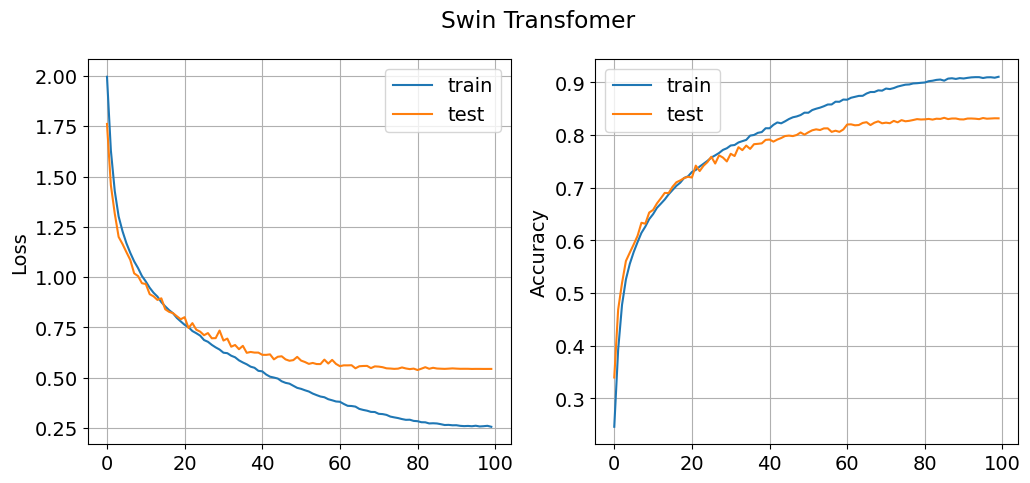

In [24]:
def visualize(train_history, test_history, title=None, figsize=(12,5)):
    train_history = np.array(train_history)
    test_history = np.array(test_history)

    plt.figure(figsize=figsize)
    plt.suptitle(title)

    # Plot training vs testing loss.
    ax = plt.subplot(1, 2, 1)
    ax.set_ylabel('Loss')
    ax.plot(train_history[:, 0], train_history[:, 1], label='train')
    ax.plot(test_history[:, 0], test_history[:, 1], label='test')
    ax.legend()

    # Plot training vs testing accuracy.
    ax = plt.subplot(1, 2, 2)
    ax.set_ylabel('Accuracy')
    ax.plot(train_history[:, 0], train_history[:, 2], label='train')
    ax.plot(test_history[:, 0], test_history[:, 2], label='test')
    ax.legend()

    plt.show()


visualize(train_history, test_history, 'Swin Transfomer')